TensorFlow Hub是共享预训练模型组件的一种方式。有关预训练模型的可搜索列表，请参见TensorFlow模块中心。本教程演示：

1. TensorFlow Hub如何与结合使用tf.keras。
1. 如何使用TensorFlow Hub进行图像分类
1. 如何进行简单的迁移学习。

设定

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

import tensorflow as tf

In [2]:
# !pip install -q -U tensorflow_hub
import tensorflow_hub as hub

from tensorflow.keras import layers

ImageNet分类器

下载分类器

使用hub.module加载mobilenet，并tf.keras.layers.Lambda包裹起来作为keras层。hub.tensorflow.google.cn中任何与TensorFlow 2兼容的图像分类器URL都可以在这里使用。

In [3]:
classifier_url ="https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

在单个图像上运行

下载单个图像以尝试模型。

65536/61306 [================================] - 0s 3us/step


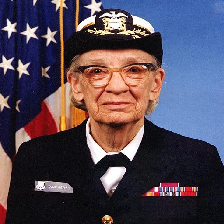

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

添加批次尺寸，然后将图像传递给模型。

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

结果是logit的1001元素向量，对图像的每个类别的概率进行评级。

因此，可以使用argmax找到顶级类ID：

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

解码预测

我们具有预测的类ID，获取ImageNet标签并解码预测

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 5us/step


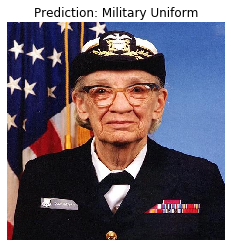

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

简单的转移学习

使用TF Hub可以轻松地重新训练模型的顶层，以识别数据集中的类。

数据集

对于此示例，您将使用TensorFlow flowers数据集：

In [11]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 890s 4us/step


将此数据加载到模型中的最简单方法是使用tf.keras.preprocessing.image.ImageDataGenerator，

TensorFlow Hub的所有图像模块都希望浮点输入在该[0, 1]范围内。使用ImageDataGenerator的rescale参数可实现此目的。

图像尺寸将在以后处理。

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


结果对象是返回image_batch, label_batch对的迭代器。

In [13]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


在一批图像上运行分类器

现在在图像批处理上运行分类器。

In [14]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [15]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['vase', 'boathouse', 'cardoon', 'buckeye', 'coil', 'daisy',
       'daisy', 'Bedlington terrier', 'coral fungus', 'daisy', 'daisy',
       'porcupine', 'daisy', 'daisy', 'daisy', 'volcano', 'wooden spoon',
       'daisy', 'daisy', 'vase', 'picket fence', 'spider web', 'daisy',
       'daisy', 'buckeye', 'greenhouse', 'torch', 'pinwheel', 'daisy',
       'daisy', 'daisy', 'barn'], dtype='<U30')

现在检查这些预测如何与图像对齐：

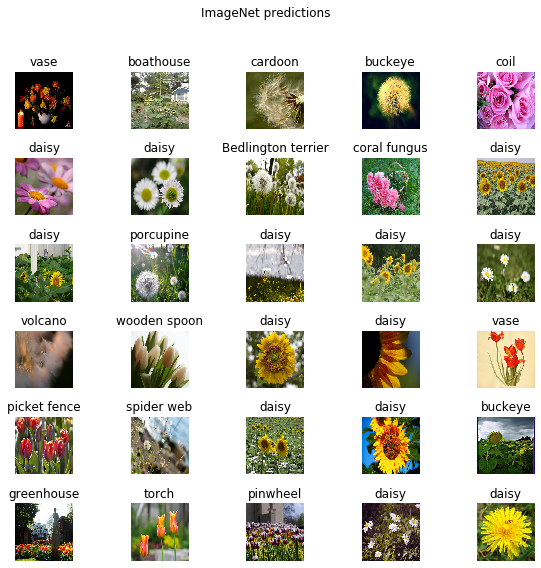

In [16]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

请参阅LICENSE.txt文件以获取图像归因。

结果远非完美，但考虑到这些不是模型训练的类别（“雏菊”除外），这是合理的。

下载无头模型

TensorFlow Hub还可以分发没有顶层分类层的模型。这些可以用来轻松地进行迁移学习。

hub.tensorflow.google.cn中任何与Tensorflow 2兼容的图像特征矢量URL都可以在这里使用。

In [17]:
feature_extractor_url = "https://hub.tensorflow.google.cn/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

创建特征提取器。

In [18]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

它为每个图像返回1280个长度的向量：

In [19]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


在特征提取器层中冻结变量，以便训练仅修改新的分类器层。

In [20]:
feature_extractor_layer.trainable = False

附上分类头

现在将中心层包装在tf.keras.Sequential模型中，并添加一个新的分类层。

In [21]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
predictions = model(image_batch)

In [23]:
predictions.shape

TensorShape([32, 5])

训练模型

使用编译来配置训练过程：

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc'])

现在使用该.fit方法训练模型。

为了使该示例短时训练仅2个纪元。要可视化训练进度，请使用自定义回调来单独记录每个批次的损失和准确性，而不是历时平均值。

In [25]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [26]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 45s 394ms/step - loss: 0.6825 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 40s 351ms/step - loss: 0.3402 - acc: 0.8750


现在，即使只是几次训练迭代，我们已经可以看到模型在任务上取得了进展。

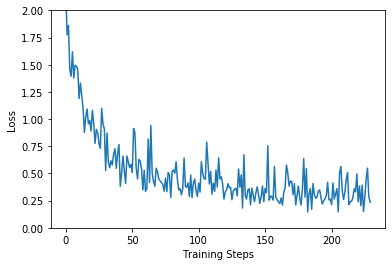

In [27]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

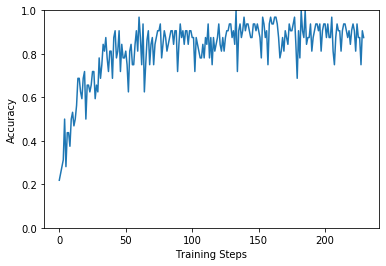

In [28]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

检查预测

要重做之前的图，请首先获取类名称的有序列表：

In [29]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

通过模型运行图像批处理并将索引转换为类名称。

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

绘制结果

In [31]:
label_id = np.argmax(label_batch, axis=-1)

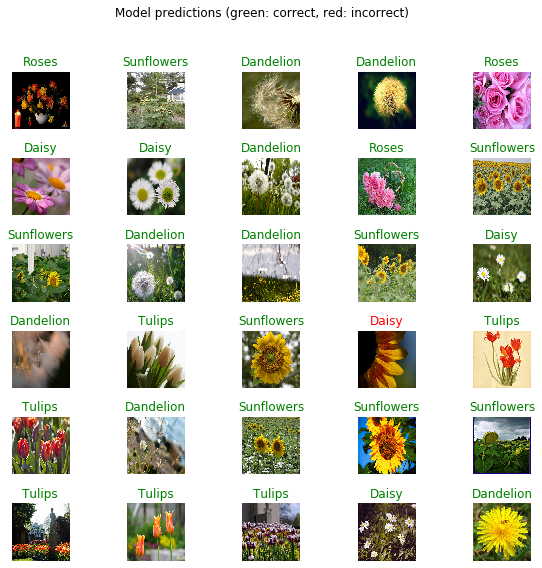

In [32]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

导出模型

现在您已经训练了模型，将其导出为保存的模型：

In [33]:
import time
t = time.time()

export_path = "./7-3/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.


Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: ./7-3/saved_models/1571653765\saved_model.pb


INFO:tensorflow:SavedModel written to: ./7-3/saved_models/1571653765\saved_model.pb


'./7-3/saved_models/1571653765'

现在确认我们可以重新加载它，并且仍然得到相同的结果：

In [34]:
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.


In [35]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [36]:
abs(reloaded_result_batch - result_batch).max()

0.0